In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [4]:
def dice_score(y_true, y_pred, label):
    y_true_bin = (y_true == label).astype(np.uint8)
    y_pred_bin = (y_pred == label).astype(np.uint8)
    intersection = np.sum(y_true_bin * y_pred_bin)
    return (2. * intersection) / (np.sum(y_true_bin) + np.sum(y_pred_bin) + 1e-8)

def dice_whole_tumor(y_true, y_pred, new_data=False):
    if new_data:
        labels = [1, 2, 3]
    else:
        labels = [1, 2, 4]
    y_true_bin = np.isin(y_true, labels).astype(np.uint8)
    y_pred_bin = np.isin(y_pred, labels).astype(np.uint8)
    intersection = np.sum(y_true_bin * y_pred_bin)
    return (2. * intersection) / (np.sum(y_true_bin) + np.sum(y_pred_bin) + 1e-8)

def get_id_from_filename(name):
    return name.split("_")[1]

def evaluate(seg_dir, pred_dir, new_data=False):
    if new_data:
        labels = [1, 2, 3]
    else:
        labels = [1, 2, 4]
    results = {}

    for seg_name in tqdm(os.listdir(seg_dir)):
        if not seg_name.endswith(".nii.gz"):
            continue

        case_id = get_id_from_filename(seg_name)
        pred_name = f"{case_id}.nii.gz"

        seg_path = os.path.join(seg_dir, seg_name)
        pred_path = os.path.join(pred_dir, pred_name)

        if not os.path.exists(pred_path):
            print(f"Prediction not found for {case_id}")
            continue

        seg_img = nib.load(seg_path).get_fdata()
        pred_img = nib.load(pred_path).get_fdata()
        if new_data:
            pred_img = np.copy(pred_img)
            pred_img[pred_img == 4] = 3

        case_result = {}
        for l in labels:
            dice = dice_score(seg_img, pred_img, l)
            case_result[f"Dice_label_{l}"] = dice

        wt_dice = dice_whole_tumor(seg_img, pred_img)
        case_result["Dice_whole_tumor"] = wt_dice

        results[case_id] = case_result

    return results

In [7]:
seg_dir = "../brats_data/BraTS2021/segmentation"
pred_dir = "../brats_data/BraTS2021/output"
results = evaluate(seg_dir, pred_dir)

for case, scores in results.items():
    print(f"{case}:")
    for label, dice in scores.items():
        print(f"  {label}: {dice:.4f}")

KeyboardInterrupt: 

In [5]:
def compute_results(dataset_name):
    seg_dir = f"../brats_data/{dataset_name}/segmentation"
    pred_dir = f"../brats_data/{dataset_name}/output"
    results_dir = f"results"
    results_file = f"{dataset_name}_results.csv"
    new_data = False if dataset_name == "BraTS2021" else True
    results = evaluate(seg_dir, pred_dir, new_data=new_data)

    rows = []
    for case, scores in results.items():
        row = {'Case': case}
        row.update(scores)
        rows.append(row)
        # print(f"{case}:")
        # for label, dice in scores.items():
        #     print(f"  {label}: {dice:.4f}")

    df = pd.DataFrame(rows)
    df.columns = ['Case', 'Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor']
    
    df.to_csv(os.path.join(results_dir, results_file), index=False)
    print(f"Computing for {dataset_name} completed 🟢")

In [6]:
datasets = ["BraTS2021", "BraTS2024-Pre", "BraTS2024-Post", "BraTSafrica"]
for dataset in datasets:
    compute_results(dataset)

100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


Computing for BraTS2021 completed 🟢


100%|██████████| 106/106 [00:18<00:00,  5.88it/s]


Computing for BraTS2024-Pre completed 🟢


100%|██████████| 200/200 [00:36<00:00,  5.54it/s]


Computing for BraTS2024-Post completed 🟢


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]

Computing for BraTSafrica completed 🟢


In [34]:
def plot_segmentation_slice(seg_path, title=None):
    # Load volume
    seg = nib.load(seg_path).get_fdata()
    
    # Find slice with largest tumor area
    sum_per_slice = [np.sum(seg[:, :, i] > 0) for i in range(seg.shape[2])]
    if max(sum_per_slice) == 0:
        print("No tumor found in the volume.")
        return
    best_slice_idx = np.argmax(sum_per_slice)
    seg_slice = seg[:, :, best_slice_idx]

    # Prepare RGB overlay
    rgb = np.zeros(seg_slice.shape + (3,), dtype=np.uint8)

    label_map = {
        1: [255, 0, 0],    # Tumor core – red
        2: [0, 255, 0],    # Edema – green
        4: [0, 0, 255],    # Enhancing tumor – blue
    }

    for label, color in label_map.items():
        rgb[seg_slice == label] = color

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.title(title or f"Segmentation Slice (slice {best_slice_idx})")
    plt.axis('off')
    plt.show()


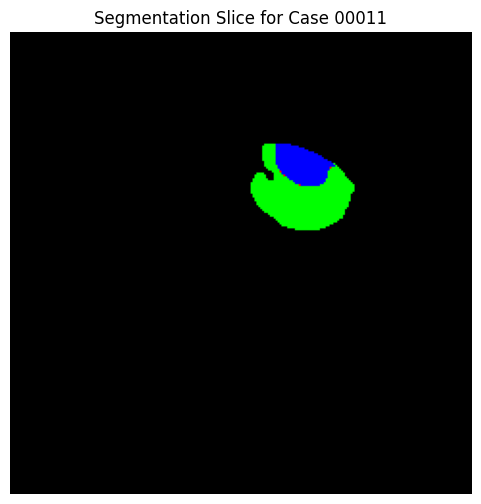

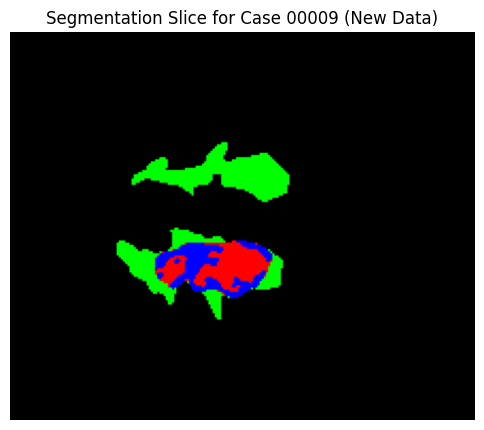

In [30]:
plot_segmentation_slice(seg_path=r'../brats_data/BraTS2021\output\00011.nii.gz', title="Segmentation Slice for Case 00011")
plot_segmentation_slice(seg_path=r'../brats_data/BraTS2024-Post\output\02770.nii.gz', title="Segmentation Slice for Case 00009 (New Data)")